<a href="https://colab.research.google.com/github/aninsung/Machine-Learning-Programming/blob/main/2%EC%A3%BC%EC%B0%A8%20/%EA%B3%BC%EC%A0%9Ccnn(wisdm).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 숙제
#### 코드를 conv1d or conv2d 를 완성한다.
#### get_frame의 함수의 코드를 이해한다.
#### 슬라이딩 윈도우 과 오버래핑을 어떻게 작동되는지 이해한다.


순환 데이터는 rnn을 사용하는데
cnn 넣을떄 순환데이터 처럼 넣어야한다.
상황마다 슬라이딩 윈도우가 다르다.



In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

In [5]:
file = open('/content/drive/MyDrive/기계학습프로그래밍/엑셀파일/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


lines: 원본 데이터 (문자열 형태, 줄 단위).

line.split(','): CSV 형태의 데이터라 가정.

line[5]: 6번째 값에서 ; 앞까지만 추출 → 공백 제거.

그 값이 비어 있으면 루프 전체 종료.

그렇지 않으면 앞의 5개 값 + 가공한 6번째 값을 **processedList**에 추가.

In [6]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']
df = pd.DataFrame(data = processedList, columns = columns)
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [7]:
# 결측치 확인
df.isnull().sum()

,0
user,0
activity,0
time,0
x,0
y,0
z,0


In [8]:
# 결측치 제거
df = df.dropna()
df.isnull().sum()

,0
user,0
activity,0
time,0
x,0
y,0
z,0


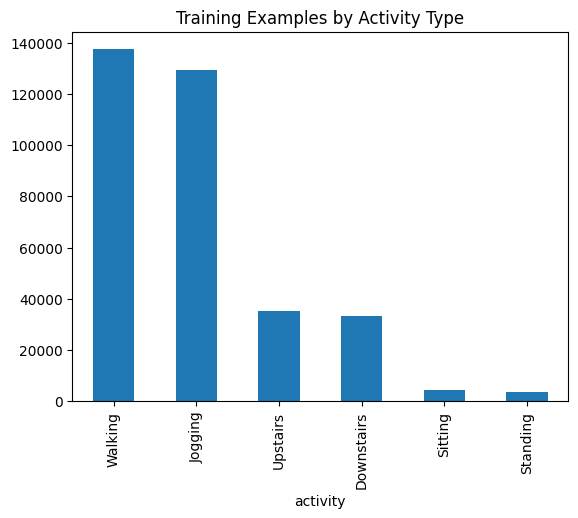

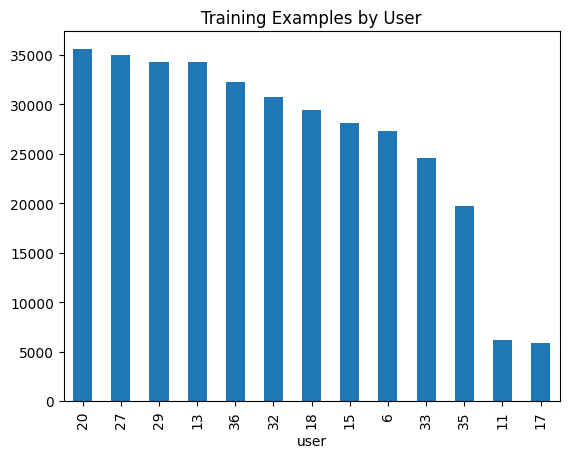

In [9]:
# Show how many training examples exist for each of the six activities
df["activity"].value_counts().plot(kind = "bar", title = "Training Examples by Activity Type")
plt.show()
# Better understand how the recordings are spread across the different users who participated in the study
df["user"].value_counts().plot(kind = "bar", title = "Training Examples by User")
plt.show()

In [10]:
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')


activities = df['activity'].value_counts().index
label = LabelEncoder()
df['activity'] = label.fit_transform(df['activity'])
df.head()

,user,activity,time,x,y,z
0,33,1,49105962326000,-0.694638,12.680544,0.503953
1,33,1,49106062271000,5.012288,11.264028,0.953424
2,33,1,49106112167000,4.903325,10.882658,-0.081722
3,33,1,49106222305000,-0.612916,18.496431,3.023717
4,33,1,49106332290000,-1.184970,12.108489,7.205164


In [11]:
activities

Index(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing'], dtype='object', name='activity')

In [12]:
num_classes = 2 # static activity 갯수
from sklearn import preprocessing

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())
X = df[['x', 'y', 'z']]
y = df['ActivityEncoded']
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,-0.258214,0.697059,0.044419,1
1,0.607502,0.483225,0.145310,1
2,0.590972,0.425654,-0.087046,1
3,-0.245817,1.575011,0.610023,1
4,-0.332596,0.610703,1.548620,1
...,...,...,...,...
343411,-0.105815,0.402609,-0.059530,5
343412,0.265839,0.435820,0.120852,5
343413,-0.031484,0.315054,0.230915,5
343414,-0.391003,0.094656,0.249259,5


원래 데이터: x, y, z 센서 값 + 문자열 라벨(activity)

처리 후:

문자열 라벨 → 숫자로 인코딩

x, y, z → 표준화(스케일 조정)

정리된 DataFrame → scaled_X

In [13]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

샘플링 주파수 Fs = 20Hz

frame_size = 80 (즉 4초), hop_size = 40 (2초 stride)

In [14]:
def get_frames(df, frame_size, hop_size):
    frames = []
    labels = []

    for i in range(0, len(df) - frame_size + 1, hop_size):
        x = df['x'].values[i: i + frame_size]
        y_ = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]

        label = stats.mode(df['label'][i: i + frame_size], keepdims=True).mode[0]

        frames.append([x, y_, z])
        labels.append(label)

    frames = np.array(frames, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    # CNN 입력용 4차원
    X = np.transpose(frames, (0, 2, 1))
    X = X[..., np.newaxis]

    return X, labels


## 작동방식

1.센서(x, y, z)랑 라벨(label) 있는 데이터프레임 받음.

2.frame_size(80) 길이만큼 잘라서 hop_size(40)만큼 이동하면서 프레임 만들기.

3.각 프레임에서 x, y, z 값 배열로 가져오기.

4.프레임 안에 여러 라벨 있으면 최빈값으로 대표 라벨 지정.

5.프레임과 라벨 리스트 넘파이 배열로 바꾸기.

6.(프레임, 3, 길이) → (프레임, 길이, 3, 1)로 바꿔서 CNN 입력 가능하게 만들기.

7.X = CNN 입력, labels = 각 프레임 라벨

## 원리


frame_size 길이만큼 데이터를 잘라서 하나의 프레임으로 만들고,

hop_size만큼 옆으로 이동하면서 다음 프레임 생성 → 겹치기도 가능(보통 50%).

프레임 라벨 결정

프레임 안에 여러 라벨이 있으면 stats.mode로 최빈값 라벨을 대표값으로 사용.

이유: 긴 창은 전이 구간 때문에 라벨이 섞일 수 있음.

CNN/RNN 입력용 변환

원본 데이터는 길이가 제각각이라 그대로 학습 불가 → 고정 길이 프레임으로 나눠서 배치 학습 가능하게 만듦.

오버프레임-> 겹치는 부분으로 인해 시계열 데이터 특징을 반영 가능

In [15]:
X, y = get_frames(scaled_X, frame_size, hop_size)

In [16]:
X.shape, y.shape

((8584, 80, 3, 1), (8584,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [18]:
X_train.shape, X_test.shape

((6867, 80, 3, 1), (1717, 80, 3, 1))

In [19]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [20]:
X.shape, y.shape

((8584, 80, 3, 1), (8584,))

In [21]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [23]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))


In [25]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 79, 2, 16)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 79, 2, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 78, 1, 32)      │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 78, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2496)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       159,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,358 (634.21 KB)

 Trainable params: 162,358 (634.21 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [26]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.6265 - loss: 0.9947 - val_accuracy: 0.8346 - val_loss: 0.4921
Epoch 2/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8181 - loss: 0.5155 - val_accuracy: 0.8655 - val_loss: 0.3805
Epoch 3/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8508 - loss: 0.3979 - val_accuracy: 0.8736 - val_loss: 0.3242
Epoch 4/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8700 - loss: 0.3358 - val_accuracy: 0.8998 - val_loss: 0.3054
Epoch 5/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.8789 - loss: 0.3021 - val_accuracy: 0.9097 - val_loss: 0.2406
Epoch 6/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8950 - loss: 0.2566 - val_accuracy: 0.9121 - val_loss: 0.2236
Epoch 7/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9159 - loss: 0.2095 - val_accuracy: 0.9255 - val_loss: 0.2411
Epoch 8/10
215/215 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9198 - loss: 0.2112 - val_accu

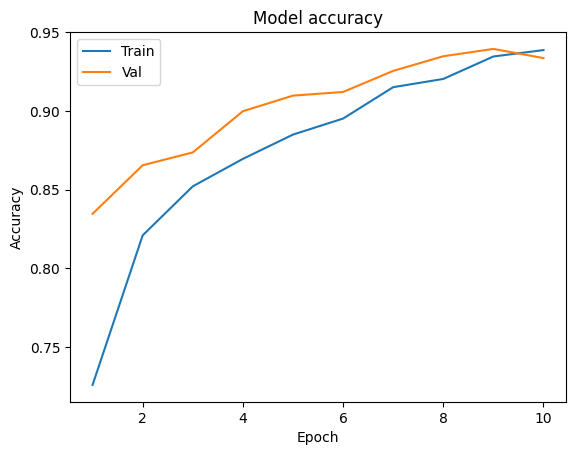

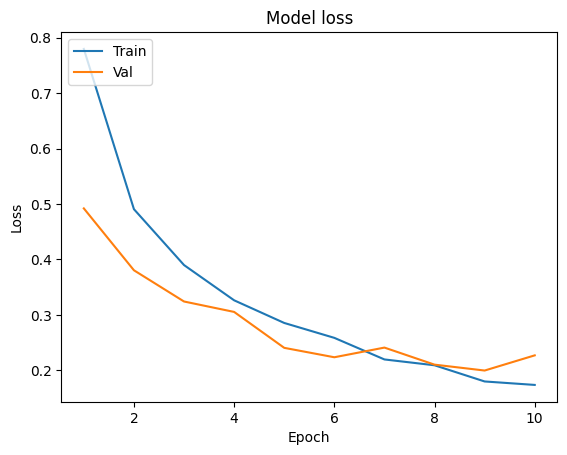

In [27]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
plot_learningCurve(history, 10)

In [28]:
model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9448 - loss: 0.2071
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


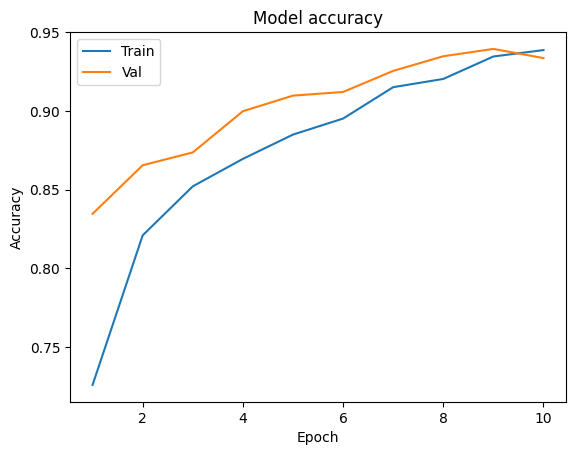

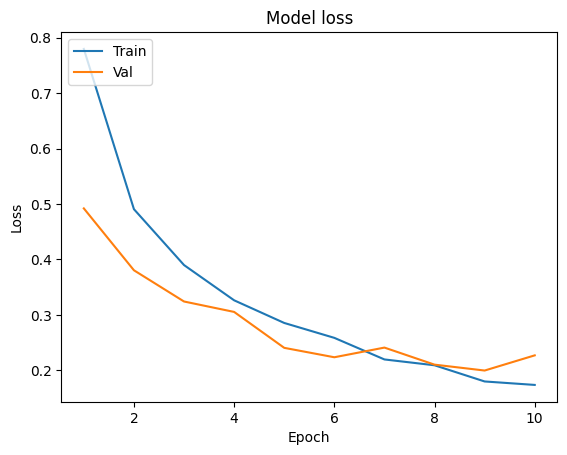

In [30]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()
plot_learningCurve(history, 10)